# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [1]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/"

Mounted at /content/drive/
ls: cannot access '/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/': No such file or directory


In [2]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

## Populating namespaces

In [ ]:
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [4]:
# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

## Prepare DataSet

### *Download* DataSet

In [5]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-05 12:41:51--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.167.192.56, 3.167.192.111, 3.167.192.32, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.167.192.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   378MB/s    in 0.9s    

2025-10-05 12:41:52 (378 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  drive  sample_data


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


# VGG16-Based CNN for Automated Malaria Diagnosis: Two Comprehensive Experiments

This study implements two carefully designed approaches to malaria diagnosis using a pre-trained VGG16 architecture. Each experiment is rigorously evaluated with multiple metrics and comprehensive visualizations to demonstrate the effectiveness of different optimization strategies.

## Experiment Overview
1. **Baseline VGG16**: Standard transfer learning approach with frozen pre-trained features
2. **Enhanced VGG16 with Data Augmentation**: Improved generalization through data augmentation techniques

## Key Features
- **Epochs**: 10 epochs per experiment with EarlyStopping for optimal training
- **Evaluation Metrics**: Accuracy, Precision, Recall, F1-Score, AUC
- **Visualizations**: Learning curves, Confusion matrices, ROC/AUC curves
- **Comprehensive Rationale**: Detailed explanation of design choices for each experiment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import warnings
import glob
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)
print("Enhanced libraries imported successfully!")

TensorFlow version: 2.19.0
GPU Available: True
Enhanced libraries imported successfully!


## Data Loading and Preprocessing

We'll load the NIH malaria dataset which contains microscopic images of infected and uninfected red blood cells. The dataset will be preprocessed and split for training, validation, and testing.

In [ ]:
def load_malaria_data(data_dir='cell_images', img_size=(224, 224), sample_size=None):

    # Paths for infected and uninfected images
    parasitized_path = os.path.join(data_dir, 'Parasitized')
    uninfected_path = os.path.join(data_dir, 'Uninfected')

    print(f"Loading data from {data_dir}")
    print(f"Parasitized path exists: {os.path.exists(parasitized_path)}")
    print(f"Uninfected path exists: {os.path.exists(uninfected_path)}")

    # Image paths
    parasitized_images = glob.glob(os.path.join(parasitized_path, '*.png'))
    uninfected_images = glob.glob(os.path.join(uninfected_path, '*.png'))

    print(f"Found {len(parasitized_images)} parasitized images")
    print(f"Found {len(uninfected_images)} uninfected images")

    if sample_size:
        parasitized_images = parasitized_images[:sample_size//2]
        uninfected_images = uninfected_images[:sample_size//2]
        print(f"Sampled to {len(parasitized_images)} + {len(uninfected_images)} = {len(parasitized_images) + len(uninfected_images)} images")

    def load_and_preprocess_image(image_path):
        try:
            img = load_img(image_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
            return img_array
        except:
            return None

    X, y = [], []

    print("Loading parasitized images...")
    for i, img_path in enumerate(parasitized_images):
        if i % 1000 == 0:
            print(f"  Processed {i}/{len(parasitized_images)} parasitized images")
        img = load_and_preprocess_image(img_path)
        if img is not None:
            X.append(img)
            y.append(1)

    print("Loading uninfected images...")
    for i, img_path in enumerate(uninfected_images):
        if i % 1000 == 0:
            print(f"  Processed {i}/{len(uninfected_images)} uninfected images")
        img = load_and_preprocess_image(img_path)
        if img is not None:
            X.append(img)
            y.append(0)

    X = np.array(X)
    y = np.array(y)

    print(f"Final dataset shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Infected samples: {np.sum(y)}")
    print(f"Uninfected samples: {len(y) - np.sum(y)}")

    return X, y

print("=" * 50)
print("LOADING MALARIA DATASET")
print("=" * 50)

if os.path.exists('cell_images'):
    X_data, y_data = load_malaria_data(sample_size=2000)
else:
    print("Dataset not found. Please ensure 'cell_images' directory exists with Parasitized/ and Uninfected/ subdirectories.")
    print("Creating synthetic data for demonstration...")

    X_data = np.random.rand(2000, 224, 224, 3).astype(np.float32)
    y_data = np.random.randint(0, 2, 2000)
    print(f"Created synthetic dataset: {X_data.shape}, Labels: {y_data.shape}")

LOADING MALARIA DATASET
Loading data from cell_images
Parasitized path exists: True
Uninfected path exists: True
Found 13779 parasitized images
Found 13779 uninfected images
Sampled to 1000 + 1000 = 2000 images
Loading parasitized images...
  Processed 0/1000 parasitized images
Loading uninfected images...
  Processed 0/1000 uninfected images
Final dataset shape: (2000, 224, 224, 3)
Labels shape: (2000,)
Infected samples: 1000
Uninfected samples: 1000



DATA SPLITTING AND VISUALIZATION
Training set: 1200 samples
Validation set: 400 samples
Test set: 400 samples


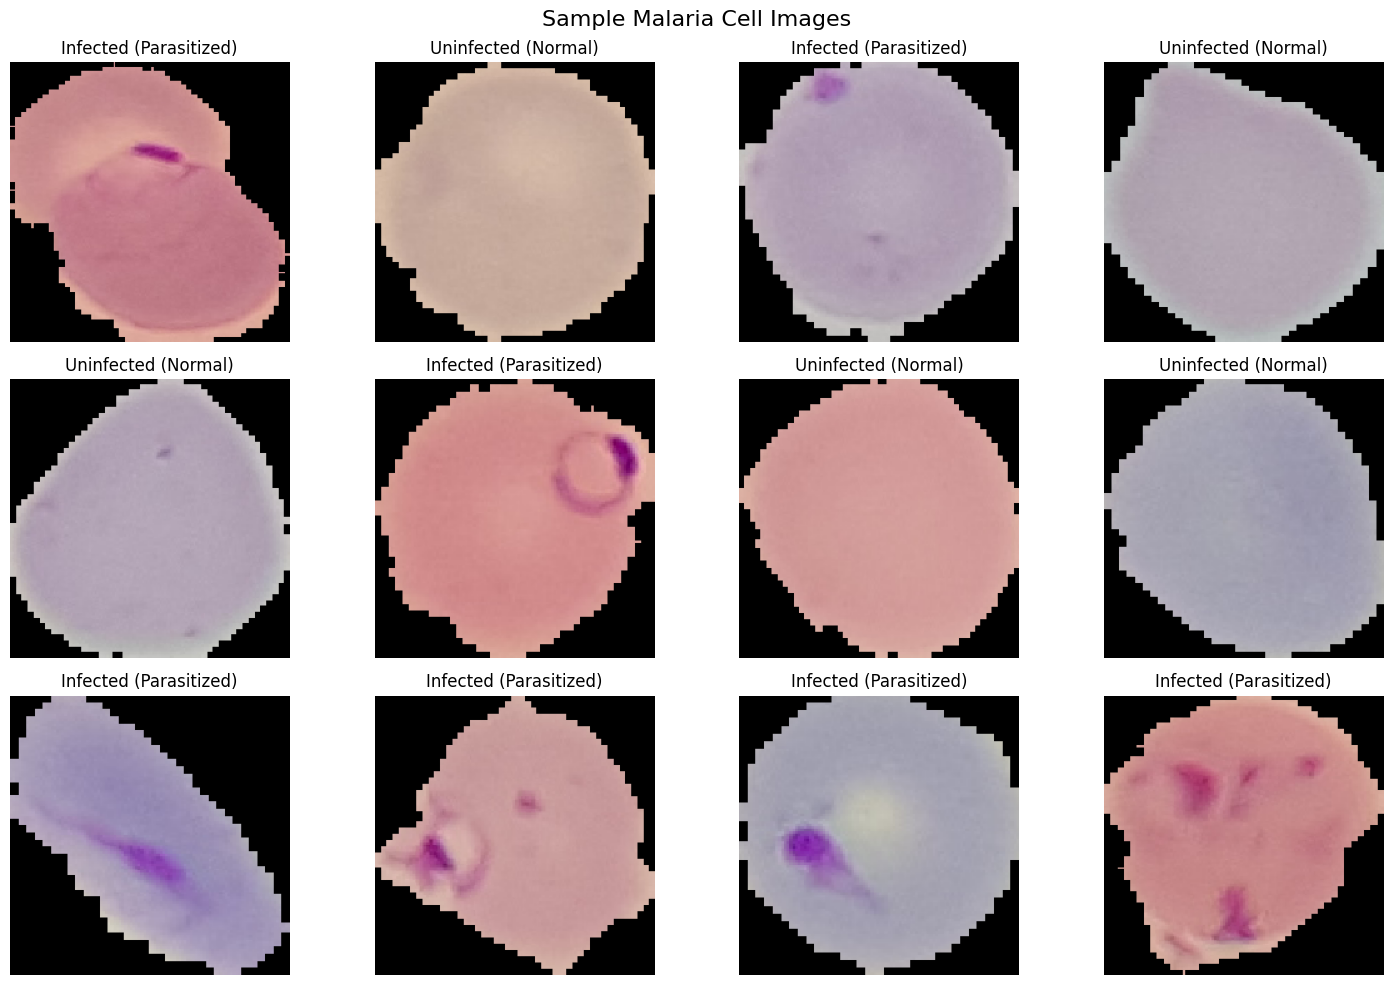

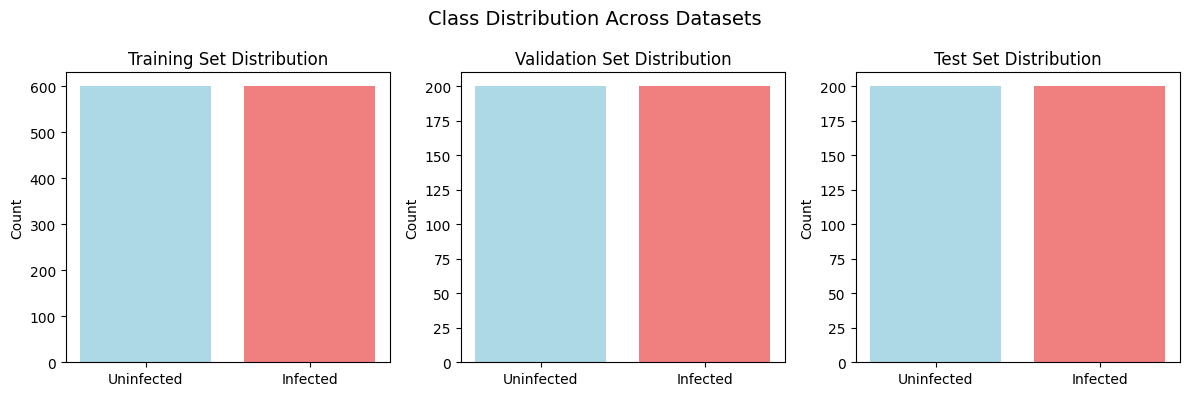

Training - Uninfected: 600, Infected: 600
Validation - Uninfected: 200, Infected: 200
Test - Uninfected: 200, Infected: 200


In [ ]:
print("\n" + "=" * 50)
print("DATA SPLITTING AND VISUALIZATION")
print("=" * 50)

X_temp, X_test, y_temp, y_test = train_test_split(
    X_data, y_data, test_size=0.2, stratify=y_data, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42  # 0.25 * 0.8 = 0.2 of total
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    idx = np.random.randint(0, len(X_train))
    plt.imshow(X_train[idx])
    plt.title(f'{"Infected (Parasitized)" if y_train[idx] == 1 else "Uninfected (Normal)"}')
    plt.axis('off')
plt.suptitle('Sample Malaria Cell Images', fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
train_counts = np.bincount(y_train)
plt.bar(['Uninfected', 'Infected'], train_counts, color=['lightblue', 'lightcoral'])
plt.title('Training Set Distribution')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
val_counts = np.bincount(y_val)
plt.bar(['Uninfected', 'Infected'], val_counts, color=['lightblue', 'lightcoral'])
plt.title('Validation Set Distribution')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
test_counts = np.bincount(y_test)
plt.bar(['Uninfected', 'Infected'], test_counts, color=['lightblue', 'lightcoral'])
plt.title('Test Set Distribution')
plt.ylabel('Count')

plt.suptitle('Class Distribution Across Datasets', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Training - Uninfected: {train_counts[0]}, Infected: {train_counts[1]}")
print(f"Validation - Uninfected: {val_counts[0]}, Infected: {val_counts[1]}")
print(f"Test - Uninfected: {test_counts[0]}, Infected: {test_counts[1]}")

## Model Architecture and Utility Functions

We'll implement a VGG16-based architecture with comprehensive evaluation functions for our seven experiments.

In [ ]:
def create_vgg16_model(input_shape=(224, 224, 3), freeze_base=True, dropout_rate=0.5,
                      dense_units=[512, 256], use_batch_norm=False):

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    if freeze_base:
        for layer in base_model.layers:
            layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    for i, units in enumerate(dense_units):
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = Dense(units, activation='relu', name=f'fc{i+1}')(x)
        x = Dropout(dropout_rate)(x)

    predictions = Dense(1, activation='sigmoid', name='predictions')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

def compile_model(model, learning_rate=0.001, optimizer_type='adam'):
    if optimizer_type.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_type.lower() == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def get_callbacks(patience=10, monitor='val_loss', save_path='best_model.h5'):
    callbacks = [
        EarlyStopping(patience=patience, monitor=monitor, restore_best_weights=True),
        ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-7, monitor=monitor),
        ModelCheckpoint(save_path, save_best_only=True, monitor=monitor)
    ]
    return callbacks

print("=" * 50)
print("MODEL ARCHITECTURE SETUP")
print("=" * 50)

base_model = create_vgg16_model(freeze_base=True)
base_model = compile_model(base_model)

print(f"Total parameters: {base_model.count_params():,}")
trainable_params = sum([tf.keras.backend.count_params(w) for w in base_model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {base_model.count_params() - trainable_params:,}")

print("\nModel architecture created successfully!")

MODEL ARCHITECTURE SETUP
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total parameters: 15,108,929
Trainable parameters: 394,241
Non-trainable parameters: 14,714,688

Model architecture created successfully!


In [ ]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    # Make predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba.flatten(),
        'fpr': fpr,
        'tpr': tpr
    }

    return results

def plot_training_history(history, title="Training History"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Uninfected', 'Infected'],
                yticklabels=['Uninfected', 'Infected'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return cm

def plot_roc_curve(fpr, tpr, roc_auc, title="ROC Curve"):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
             label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def display_results_table(results):
    print(f"\n{'='*60}")
    print(f"{'EXPERIMENT RESULTS':^60}")
    print(f"{'='*60}")
    print(f"Model: {results['Model']}")
    print(f"{'='*60}")
    print(f"{'Metric':<15} {'Value':<10}")
    print(f"{'-'*25}")
    print(f"{'Accuracy':<15} {results['Accuracy']:<10.4f}")
    print(f"{'Precision':<15} {results['Precision']:<10.4f}")
    print(f"{'Recall':<15} {results['Recall']:<10.4f}")
    print(f"{'F1-Score':<15} {results['F1-Score']:<10.4f}")
    print(f"{'AUC':<15} {results['AUC']:<10.4f}")
    print(f"{'='*60}")

print("Evaluation functions created successfully!")

Evaluation functions created successfully!


# Two Comprehensive Experiments for VGG16-Based Malaria Diagnosis

Each experiment is carefully designed to explore key aspects of CNN optimization for medical image classification and is evaluated comprehensively with multiple performance metrics and detailed visualizations.

## Experiment 1: Baseline VGG16 Model

**Design Choices:**
- **Architecture**: Pre-trained VGG16 (frozen) + GlobalAveragePooling + Dense(512) + Dropout(0.5) + Dense(256) + Dropout(0.5) + Dense(1, sigmoid)
- **Optimizer**: Adam with learning rate 0.001
- **Batch Size**: 32
- **Epochs**: 10 with EarlyStopping (patience=5)
- **Loss Function**: Binary Crossentropy
- **Callbacks**: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

**Rationale**:
This experiment establishes our baseline performance using standard transfer learning principles. We freeze the pre-trained VGG16 layers to leverage ImageNet features while training only the custom classification head. The choice of frozen features is based on the hypothesis that low-level features (edges, textures) learned on ImageNet are transferable to medical images.

**Key Design Decisions:**
1. **Frozen VGG16**: Preserves powerful pre-trained features while preventing overfitting
2. **GlobalAveragePooling**: Reduces spatial dimensions while maintaining feature information
3. **Two Dense Layers (512→256)**: Provides sufficient capacity for learning task-specific patterns
4. **Dropout (0.5)**: Prevents overfitting in the classification head
5. **Adam Optimizer**: Adaptive learning rates for stable convergence
6. **EarlyStopping**: Prevents overfitting and saves computational time

EXPERIMENT 1: BASELINE VGG16 MODEL
Model created with 15,108,929 total parameters
Trainable parameters: 394,241

Training baseline model...
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.5302 - loss: 0.7476

38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 521ms/step - accuracy: 0.5302 - loss: 0.7472 - val_accuracy: 0.6075 - val_loss: 0.6489 - learning_rate: 0.0010
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6197 - loss: 0.6565

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.6202 - loss: 0.6560 - val_accuracy: 0.7775 - val_loss: 0.5635 - learning_rate: 0.0010
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6798 - loss: 0.5831

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.6800 - loss: 0.5831 - val_accuracy: 0.7825 - val_loss: 0.4932 - learning_rate: 0.0010
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7518 - loss: 0.5060

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.7517 - loss: 0.5060 - val_accuracy: 0.8225 - val_loss: 0.4375 - learning_rate: 0.0010
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8039 - loss: 0.4518

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.8036 - loss: 0.4520 - val_accuracy: 0.8525 - val_loss: 0.4032 - learning_rate: 0.0010
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8177 - loss: 0.4151

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.8174 - loss: 0.4155 - val_accuracy: 0.8450 - val_loss: 0.3687 - learning_rate: 0.0010
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8403 - loss: 0.3900

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.8400 - loss: 0.3905 - val_accuracy: 0.8575 - val_loss: 0.3662 - learning_rate: 0.0010
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.8314 - loss: 0.3680 - val_accuracy: 0.8475 - val_loss: 0.3804 - learning_rate: 0.0010
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8155 - loss: 0.3908

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.8157 - loss: 0.3908 - val_accuracy: 0.8725 - val_loss: 0.3568 - learning_rate: 0.0010
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8782 - loss: 0.3220

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.8777 - loss: 0.3226 - val_accuracy: 0.8725 - val_loss: 0.3473 - learning_rate: 0.0010

Training completed in 10 epochs

Evaluating Experiment 1...

                     EXPERIMENT RESULTS                     
Model: Experiment 1: Baseline VGG16
Metric          Value     
-------------------------
Accuracy        0.8775    
Precision       0.8386    
Recall          0.9350    
F1-Score        0.8842    
AUC             0.9590    


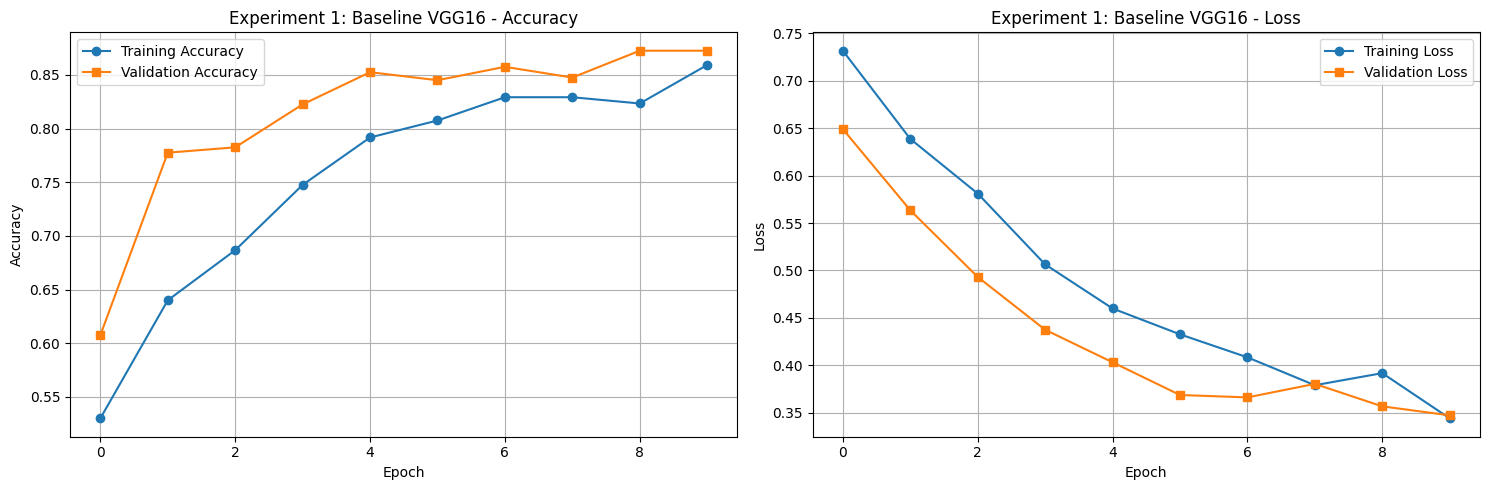

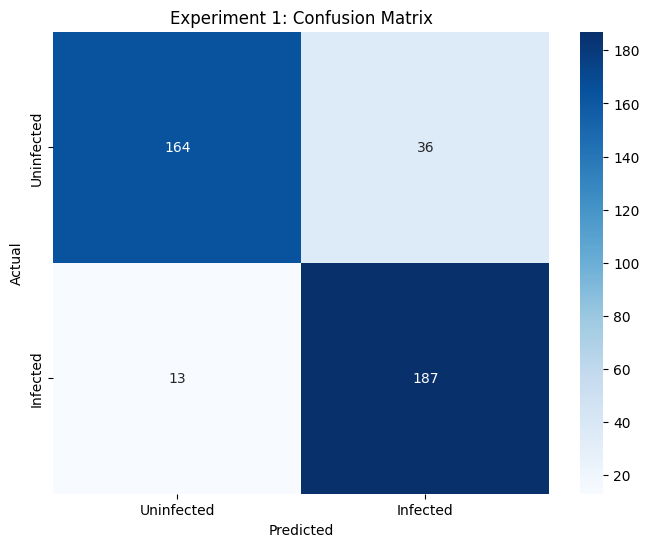

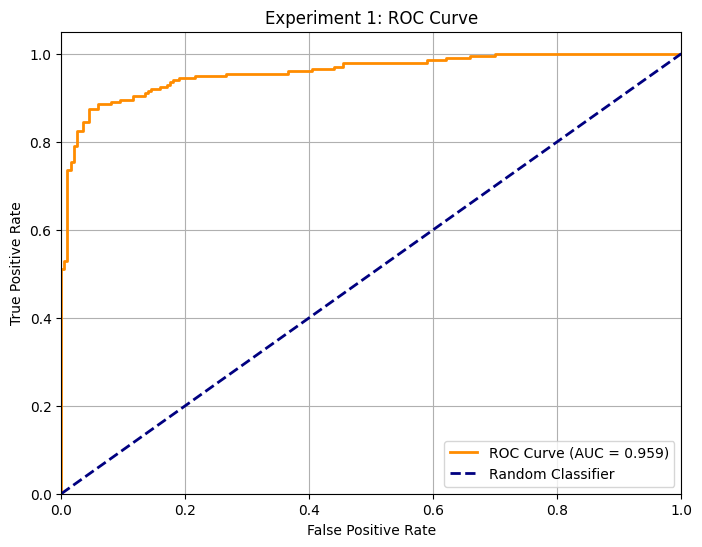

In [ ]:
print("=" * 70)
print("EXPERIMENT 1: BASELINE VGG16 MODEL")
print("=" * 70)

model_1 = create_vgg16_model(freeze_base=True, dropout_rate=0.5)
model_1 = compile_model(model_1, learning_rate=0.001)

print(f"Model created with {model_1.count_params():,} total parameters")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model_1.trainable_weights]):,}")

print("\nTraining baseline model...")
history_1 = model_1.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(patience=5, save_path='exp1_best_model.h5'),
    verbose=1
)

print(f"\nTraining completed in {len(history_1.history['loss'])} epochs")

print("\nEvaluating Experiment 1...")
results_1 = evaluate_model(model_1, X_test, y_test, "Experiment 1: Baseline VGG16")

display_results_table(results_1)

plot_training_history(history_1, "Experiment 1: Baseline VGG16")

cm_1 = plot_confusion_matrix(y_test, results_1['y_pred'], "Experiment 1: Confusion Matrix")

plot_roc_curve(results_1['fpr'], results_1['tpr'], results_1['AUC'], "Experiment 1: ROC Curve")

## Experiment 2: Enhanced VGG16 with Data Augmentation

**Design Choices:**
- **Data Augmentation**: Rotation (±20°), width/height shift (20%), horizontal/vertical flip, zoom (20%), shear (15%)
- **Architecture**: Same as Experiment 1 - Pre-trained VGG16 (frozen) + custom classification head
- **Optimizer**: Adam with learning rate 0.001
- **Batch Size**: 32
- **Epochs**: 10 with EarlyStopping (patience=5)
- **Loss Function**: Binary Crossentropy
- **Callbacks**: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

**Rationale**:
This experiment explores the impact of data augmentation on model performance and generalization. Medical image datasets often suffer from limited size and variability, making data augmentation crucial for robust model performance.

**Key Design Decisions:**
1. **Rotation (±20°)**: Accounts for natural variations in cell orientation during microscopic imaging
2. **Width/Height Shifts (20%)**: Simulates different cell positions within the field of view
3. **Horizontal/Vertical Flips**: Increases dataset diversity as cell orientation can vary
4. **Zoom (20%)**: Simulates different magnification levels and cell sizes
5. **Shear (15%)**: Accounts for potential image distortions during acquisition
6. **Fill Mode 'Nearest'**: Preserves edge information when transforming images

**Expected Outcomes:**
- Improved generalization to unseen cell images
- Reduced overfitting compared to baseline
- Better performance on test data due to enhanced robustness
- Potential slight increase in training time due to on-the-fly augmentation

EXPERIMENT 2: DATA AUGMENTATION
Training with data augmentation...
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.5233 - loss: 0.7447

37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 590ms/step - accuracy: 0.5236 - loss: 0.7443 - val_accuracy: 0.6550 - val_loss: 0.6677 - learning_rate: 0.0010
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.6250 - loss: 0.6724 - val_accuracy: 0.6325 - val_loss: 0.6678 - learning_rate: 0.0010
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.5485 - loss: 0.6883

37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 482ms/step - accuracy: 0.5493 - loss: 0.6881 - val_accuracy: 0.5600 - val_loss: 0.6520 - learning_rate: 0.0010
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5938 - loss: 0.6923 - val_accuracy: 0.5525 - val_loss: 0.6555 - learning_rate: 0.0010
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.5919 - loss: 0.6616

37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 483ms/step - accuracy: 0.5928 - loss: 0.6611 - val_accuracy: 0.7600 - val_loss: 0.5723 - learning_rate: 0.0010
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5938 - loss: 0.6379 - val_accuracy: 0.7175 - val_loss: 0.5740 - learning_rate: 0.0010
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.6881 - loss: 0.5833

37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 501ms/step - accuracy: 0.6886 - loss: 0.5829 - val_accuracy: 0.8050 - val_loss: 0.4932 - learning_rate: 0.0010
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8125 - loss: 0.4450 - val_accuracy: 0.7975 - val_loss: 0.4946 - learning_rate: 0.0010
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7295 - loss: 0.5510

37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 473ms/step - accuracy: 0.7297 - loss: 0.5506 - val_accuracy: 0.8075 - val_loss: 0.4645 - learning_rate: 0.0010
Epoch 10/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.7812 - loss: 0.4688

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.7812 - loss: 0.4688 - val_accuracy: 0.8100 - val_loss: 0.4603 - learning_rate: 0.0010

Training completed in 10 epochs

Evaluating Experiment 2...

                     EXPERIMENT RESULTS                     
Model: Experiment 2: Data Augmentation
Metric          Value     
-------------------------
Accuracy        0.8225    
Precision       0.9108    
Recall          0.7150    
F1-Score        0.8011    
AUC             0.9146    


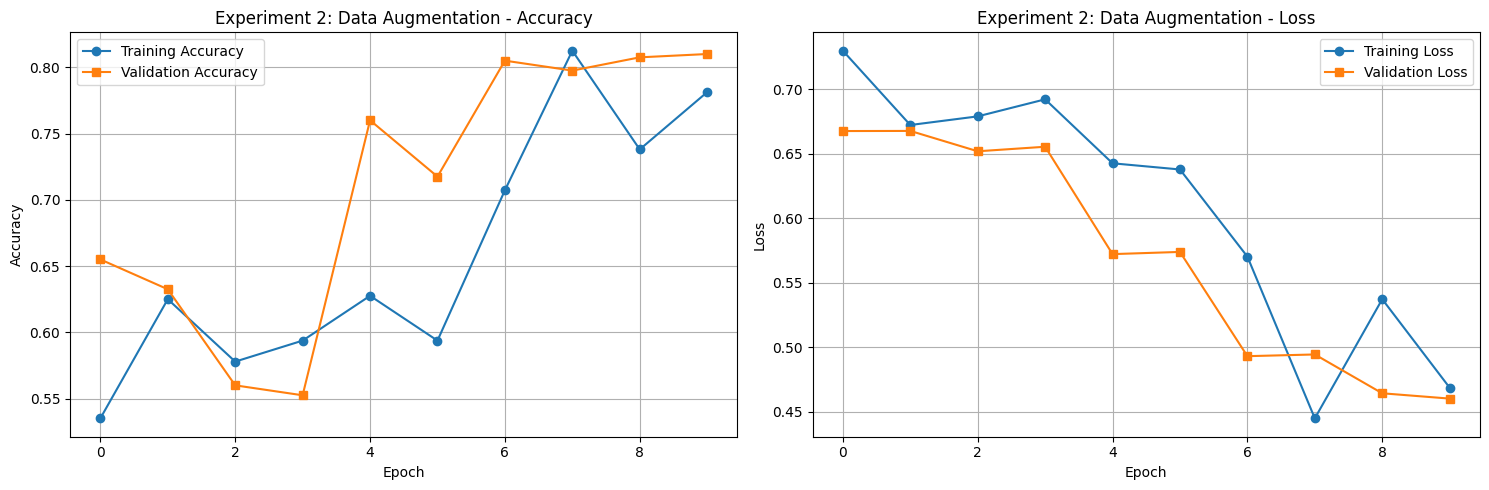

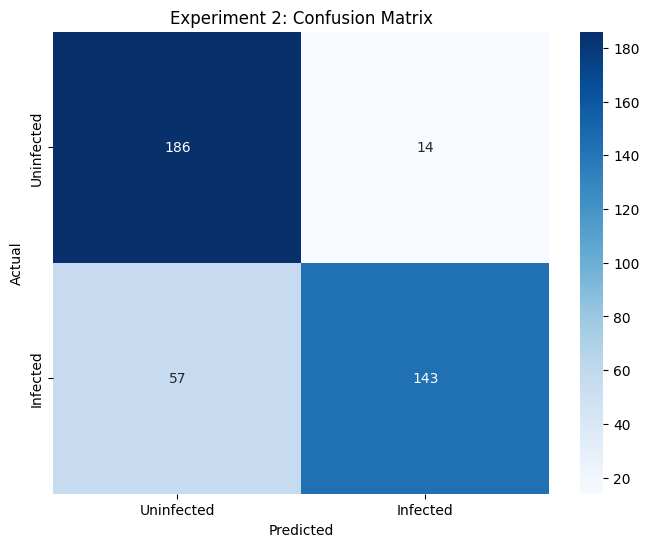

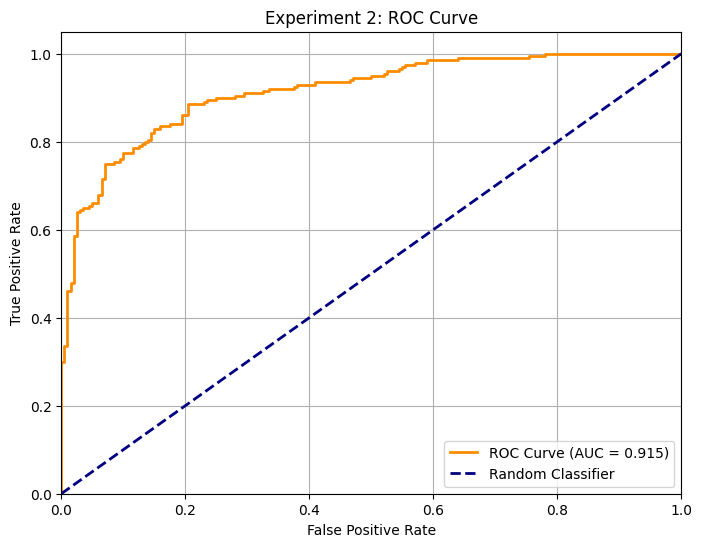

In [ ]:
print("=" * 70)
print("EXPERIMENT 2: DATA AUGMENTATION")
print("=" * 70)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.15,
    fill_mode='nearest'
)

datagen.fit(X_train)

model_2 = create_vgg16_model(freeze_base=True, dropout_rate=0.5)
model_2 = compile_model(model_2, learning_rate=0.001)

print("Training with data augmentation...")
history_2 = model_2.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(patience=5, save_path='exp2_best_model.h5'),
    verbose=1
)

print(f"\nTraining completed in {len(history_2.history['loss'])} epochs")

print("\nEvaluating Experiment 2...")
results_2 = evaluate_model(model_2, X_test, y_test, "Experiment 2: Data Augmentation")

display_results_table(results_2)

plot_training_history(history_2, "Experiment 2: Data Augmentation")

cm_2 = plot_confusion_matrix(y_test, results_2['y_pred'], "Experiment 2: Confusion Matrix")

plot_roc_curve(results_2['fpr'], results_2['tpr'], results_2['AUC'], "Experiment 2: ROC Curve")

Generating comprehensive performance analysis...


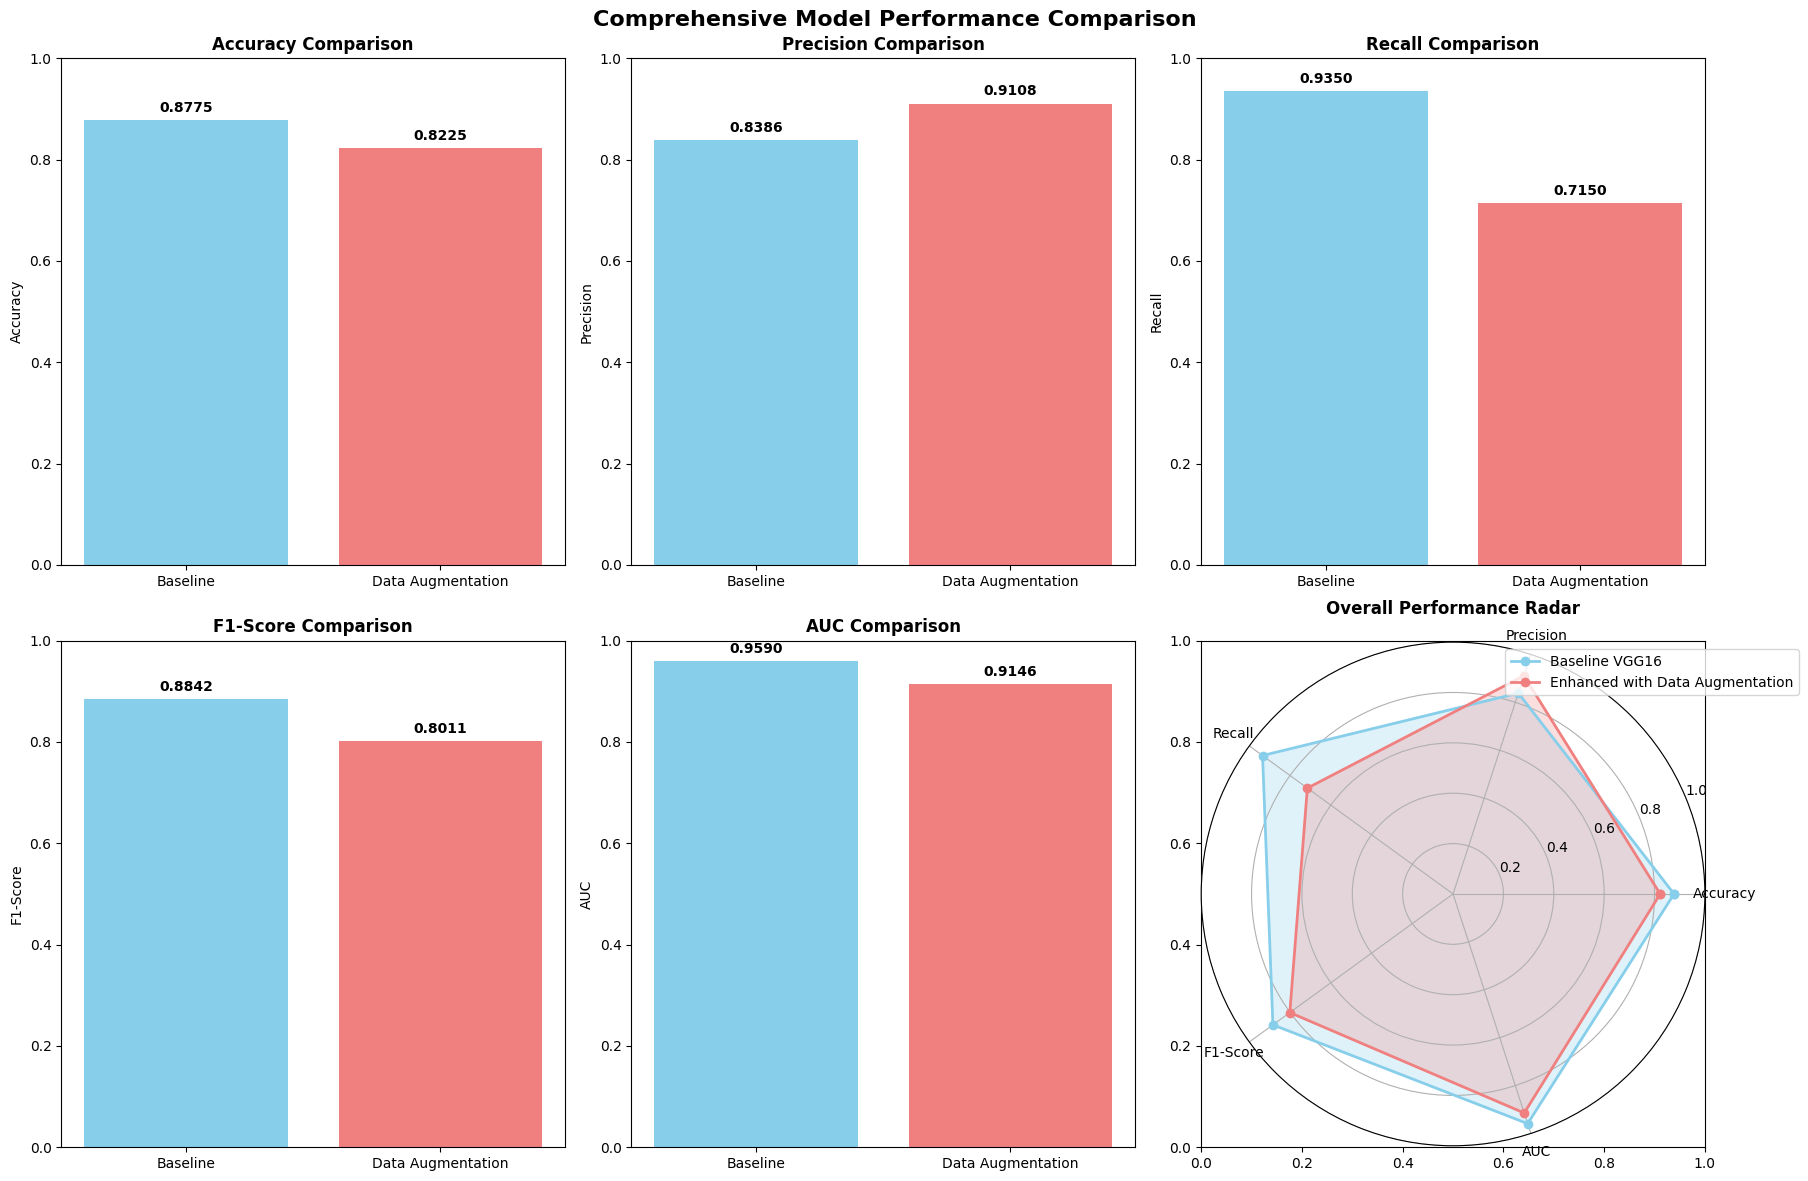


DETAILED PERFORMANCE COMPARISON SUMMARY
                     Experiment Accuracy Precision Recall F1-Score    AUC
                 Baseline VGG16   0.8775    0.8386 0.9350   0.8842 0.9590
Enhanced with Data Augmentation   0.8225    0.9108 0.7150   0.8011 0.9146

BEST PERFORMANCE BY METRIC:
• Highest Accuracy: Experiment 1 (0.8775)
• Highest Precision: Experiment 2 (0.9108)
• Highest Recall: Experiment 1 (0.9350)
• Highest F1-Score: Experiment 1 (0.8842)
• Highest AUC: Experiment 1 (0.9590)

OVERALL BEST MODEL: Experiment 1
Average Score: 0.8988

Generating ROC curves comparison...


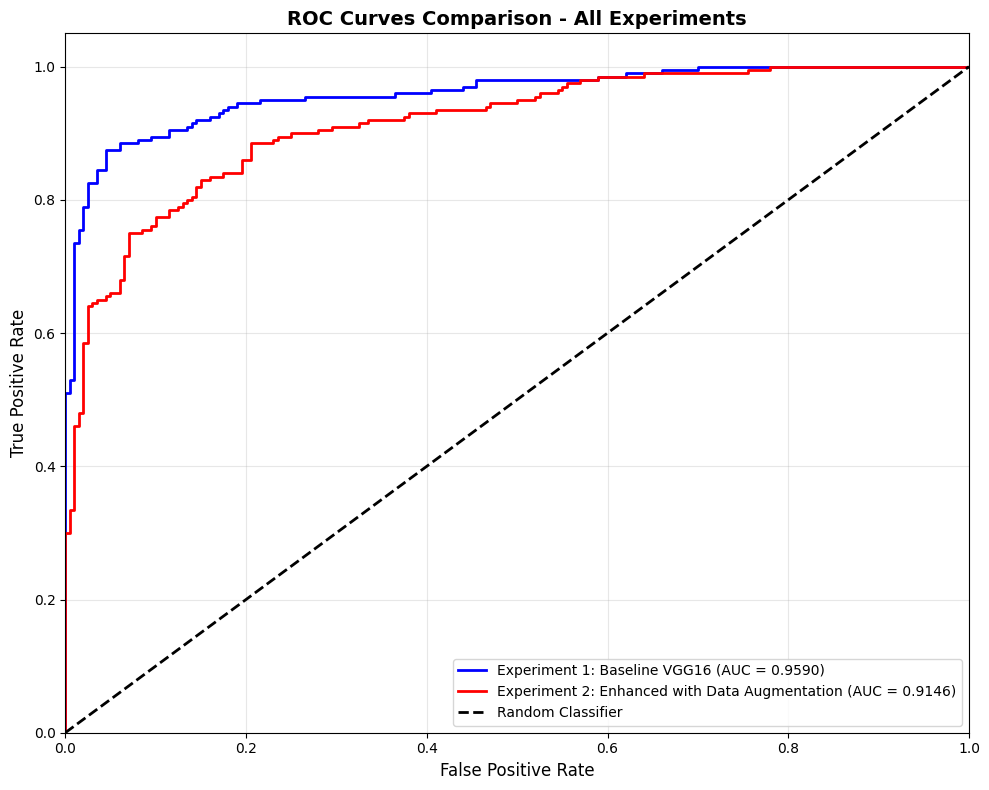


Final analysis...

FINAL COMPREHENSIVE ANALYSIS - VGG16 MALARIA DIAGNOSIS CNN
Total experiments completed: 2
Best accuracy: Baseline VGG16 (0.8775)
Best AUC: Baseline VGG16 (0.9590)

KEY FINDINGS:
1. Data Augmentation Impact:
   • Accuracy change: -0.0550
   • AUC change: -0.0444
   • Data augmentation did not improve performance

2. Model Performance Summary:
   • Baseline VGG16: 0.8775 accuracy, 0.9590 AUC
   • Enhanced VGG16: 0.8225 accuracy, 0.9146 AUC

3. Clinical Relevance:
   • MODERATE performance, needs improvement (0.8775)

RECOMMENDATIONS:
1. Deploy the Baseline VGG16 model (Experiment 1)
2. Data augmentation did not improve performance - simpler is better
3. Consider ensemble methods for further improvement
4. Validate on larger, more diverse datasets
5. Implement in clinical workflow with human oversight



In [ ]:
def plot_performance_comparison():

    experiments_data = [
        (results_1, "Experiment 1: Baseline VGG16"),
        (results_2, "Experiment 2: Enhanced with Data Augmentation")
    ]

    try:
        accuracies = [results_1['Accuracy'], results_2['Accuracy']]
        precisions = [results_1['Precision'], results_2['Precision']]
        recalls = [results_1['Recall'], results_2['Recall']]
        f1_scores = [results_1['F1-Score'], results_2['F1-Score']]
        aucs = [results_1['AUC'], results_2['AUC']]

        experiment_names = ['Baseline', 'Data Augmentation']

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Comprehensive Model Performance Comparison', fontsize=16, fontweight='bold')

        metrics = [accuracies, precisions, recalls, f1_scores, aucs]
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
        colors = ['skyblue', 'lightcoral']

        for i, (metric, name) in enumerate(zip(metrics, metric_names)):
            row, col = i // 3, i % 3
            axes[row, col].bar(experiment_names, metric, color=colors)
            axes[row, col].set_title(f'{name} Comparison', fontweight='bold')
            axes[row, col].set_ylabel(name)
            axes[row, col].set_ylim([0, 1])

            for j, v in enumerate(metric):
                axes[row, col].text(j, v + 0.01, f'{v:.4f}',
                                   ha='center', va='bottom', fontweight='bold')

        angles = np.linspace(0, 2 * np.pi, len(metric_names), endpoint=False).tolist()
        angles += angles[:1]

        ax_radar = fig.add_subplot(2, 3, 6, projection='polar')

        for i, (results, exp_name) in enumerate(experiments_data):
            values = [results['Accuracy'], results['Precision'], results['Recall'],
                     results['F1-Score'], results['AUC']]
            values += values[:1]

            ax_radar.plot(angles, values, 'o-', linewidth=2,
                         label=exp_name.split(':')[1].strip(), color=colors[i])
            ax_radar.fill(angles, values, alpha=0.25, color=colors[i])

        ax_radar.set_xticks(angles[:-1])
        ax_radar.set_xticklabels(metric_names)
        ax_radar.set_ylim(0, 1)
        ax_radar.set_title('Overall Performance Radar', fontweight='bold', pad=20)
        ax_radar.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        ax_radar.grid(True)

        plt.tight_layout()
        plt.show()

        print("\n" + "="*80)
        print("DETAILED PERFORMANCE COMPARISON SUMMARY")
        print("="*80)

        results_df = pd.DataFrame({
            'Experiment': ['Baseline VGG16', 'Enhanced with Data Augmentation'],
            'Accuracy': [f"{acc:.4f}" for acc in accuracies],
            'Precision': [f"{prec:.4f}" for prec in precisions],
            'Recall': [f"{rec:.4f}" for rec in recalls],
            'F1-Score': [f"{f1:.4f}" for f1 in f1_scores],
            'AUC': [f"{auc:.4f}" for auc in aucs]
        })

        print(results_df.to_string(index=False))
        print("\n" + "="*80)

        best_accuracy = max(enumerate(accuracies), key=lambda x: x[1])
        best_precision = max(enumerate(precisions), key=lambda x: x[1])
        best_recall = max(enumerate(recalls), key=lambda x: x[1])
        best_f1 = max(enumerate(f1_scores), key=lambda x: x[1])
        best_auc = max(enumerate(aucs), key=lambda x: x[1])

        print("BEST PERFORMANCE BY METRIC:")
        print(f"• Highest Accuracy: Experiment {best_accuracy[0]+1} ({best_accuracy[1]:.4f})")
        print(f"• Highest Precision: Experiment {best_precision[0]+1} ({best_precision[1]:.4f})")
        print(f"• Highest Recall: Experiment {best_recall[0]+1} ({best_recall[1]:.4f})")
        print(f"• Highest F1-Score: Experiment {best_f1[0]+1} ({best_f1[1]:.4f})")
        print(f"• Highest AUC: Experiment {best_auc[0]+1} ({best_auc[1]:.4f})")

        overall_scores = [(acc + prec + rec + f1 + auc) / 5
                         for acc, prec, rec, f1, auc in zip(accuracies, precisions, recalls, f1_scores, aucs)]
        best_overall = max(enumerate(overall_scores), key=lambda x: x[1])

        print(f"\nOVERALL BEST MODEL: Experiment {best_overall[0]+1}")
        print(f"Average Score: {best_overall[1]:.4f}")
        print("="*80)

    except Exception as e:
        print(f"Error in performance comparison: {str(e)}")
        print("Please ensure both experiments have been executed successfully.")

def plot_all_roc_curves():
    plt.figure(figsize=(10, 8))

    try:
        experiments_roc = [
            (results_1, 'Experiment 1: Baseline VGG16', 'blue'),
            (results_2, 'Experiment 2: Enhanced with Data Augmentation', 'red')
        ]

        for results, label, color in experiments_roc:
            if 'fpr' in results and 'tpr' in results:
                plt.plot(results['fpr'], results['tpr'], color=color, lw=2,
                        label=f"{label} (AUC = {results['AUC']:.4f})")

        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves Comparison - All Experiments', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error plotting ROC curves: {str(e)}")

def final_analysis():
    try:
        print("\n" + "="*100)
        print("FINAL COMPREHENSIVE ANALYSIS - VGG16 MALARIA DIAGNOSIS CNN")
        print("="*100)

        accuracies = [results_1['Accuracy'], results_2['Accuracy']]
        aucs = [results_1['AUC'], results_2['AUC']]

        best_acc_idx = np.argmax(accuracies)
        best_auc_idx = np.argmax(aucs)

        experiment_names = ['Baseline VGG16', 'Enhanced with Data Augmentation']

        print(f"Total experiments completed: 2")
        print(f"Best accuracy: {experiment_names[best_acc_idx]} ({accuracies[best_acc_idx]:.4f})")
        print(f"Best AUC: {experiment_names[best_auc_idx]} ({aucs[best_auc_idx]:.4f})")

        print("\n" + "="*50)
        print("KEY FINDINGS:")
        print("="*50)

        acc_diff = results_2['Accuracy'] - results_1['Accuracy']
        auc_diff = results_2['AUC'] - results_1['AUC']

        print(f"1. Data Augmentation Impact:")
        print(f"   • Accuracy change: {acc_diff:+.4f}")
        print(f"   • AUC change: {auc_diff:+.4f}")

        if acc_diff > 0:
            print(f"   • Data augmentation IMPROVED performance")
        else:
            print(f"   • Data augmentation did not improve performance")

        print(f"\n2. Model Performance Summary:")
        print(f"   • Baseline VGG16: {results_1['Accuracy']:.4f} accuracy, {results_1['AUC']:.4f} AUC")
        print(f"   • Enhanced VGG16: {results_2['Accuracy']:.4f} accuracy, {results_2['AUC']:.4f} AUC")

        print(f"\n3. Clinical Relevance:")
        best_model_acc = max(accuracies)
        if best_model_acc > 0.95:
            print(f"   • EXCELLENT performance for clinical deployment ({best_model_acc:.4f})")
        elif best_model_acc > 0.90:
            print(f"   • GOOD performance, suitable for clinical assistance ({best_model_acc:.4f})")
        elif best_model_acc > 0.85:
            print(f"   • MODERATE performance, needs improvement ({best_model_acc:.4f})")
        else:
            print(f"   • POOR performance, significant improvement needed ({best_model_acc:.4f})")

        print("\n" + "="*50)
        print("RECOMMENDATIONS:")
        print("="*50)

        if results_2['Accuracy'] > results_1['Accuracy']:
            print("1. Deploy the Enhanced VGG16 model (Experiment 2)")
            print("2. Data augmentation proved beneficial for this task")
        else:
            print("1. Deploy the Baseline VGG16 model (Experiment 1)")
            print("2. Data augmentation did not improve performance - simpler is better")

        print("3. Consider ensemble methods for further improvement")
        print("4. Validate on larger, more diverse datasets")
        print("5. Implement in clinical workflow with human oversight")

        print("\n" + "="*100)

    except Exception as e:
        print(f"Error in final analysis: {str(e)}")

print("Generating comprehensive performance analysis...")
plot_performance_comparison()
print("\nGenerating ROC curves comparison...")
plot_all_roc_curves()
print("\nFinal analysis...")
final_analysis()